<a href="https://colab.research.google.com/github/badriadhikari/IEEE-ICMLA-2019-PIDP-Challenge/blob/master/PIDP_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

job_dir =  ./

Load input features..

Load distance maps..

Some cross checks on data loading..

Find the number of input channels..

Split into training and validation set (4%)..
Total validation proteins =  8
Total training proteins =  192

Prepare the validation input and outputs..
(8, 256, 256, 13)
(8, 256, 256, 1)

Prepare the training input and outputs..
(192, 256, 256, 13)
(192, 256, 256, 1)

Sanity check input features values..
 First validation protein:
 Channel        Avg        Max        Sum
       0     0.4457     0.9970    29210.6
       1     0.4457     0.9970    29210.6
       2     0.3147     0.9930    20622.6
       3     0.3147     0.9930    20622.6
       4     0.2157     0.9920    14137.9
       5     0.2157     0.9920    14137.9
       6     0.2594     0.8880    17002.8
       7     0.2594     0.8880    17002.8
       8     0.6736     0.9460    44145.7
       9     0.6736     0.9460    44145.7
      10     0.1118     1.0000     7324.6
      11     0.1328     5.998

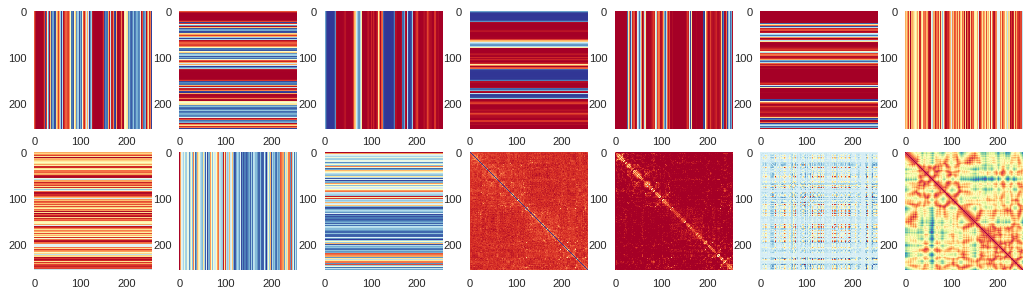

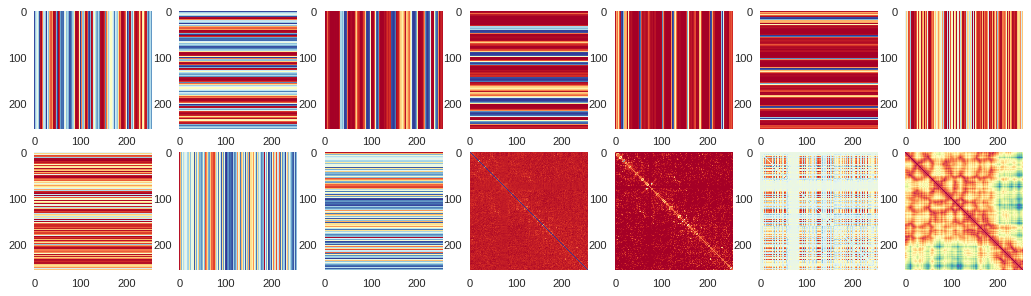

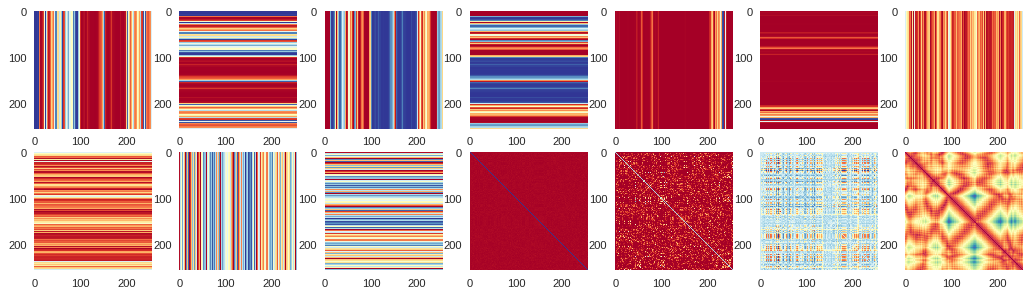

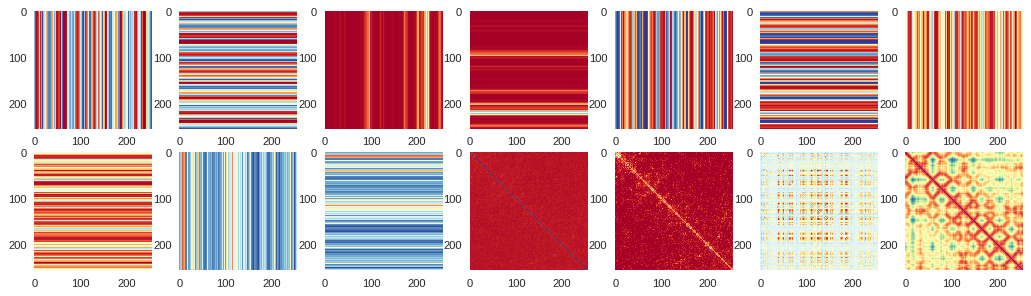


Build a model..
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 13)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 256, 13)      52        
_________________________________________________________________
activation_19 (Activation)   (None, 256, 256, 13)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 256, 64)      7552      
_________________________________________________________________
activation_20 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
activation_21 (Activation)   (None, 256, 256, 64)      0   

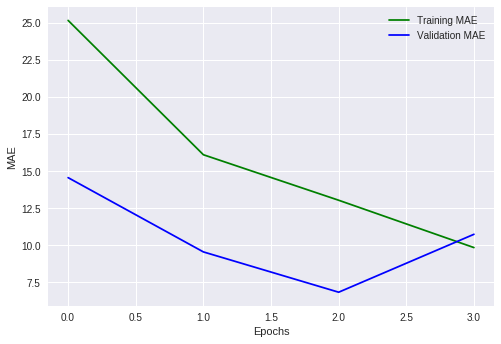


Load the best weights..

Make predictions..

Compare the predictions with the truths (for some proteins) ..


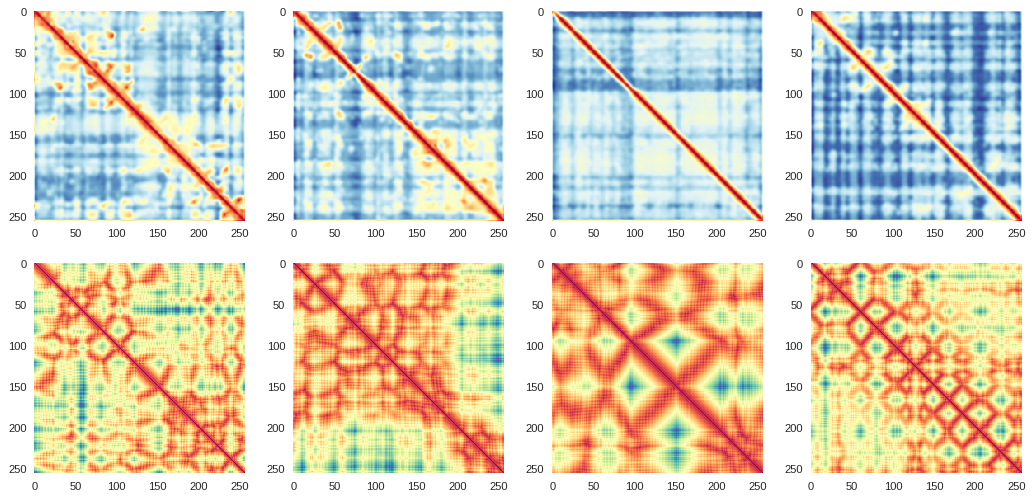


MAE of top L long-range distance predictions on the validation set..
MAE for 0 - 12asA0 = 5.68


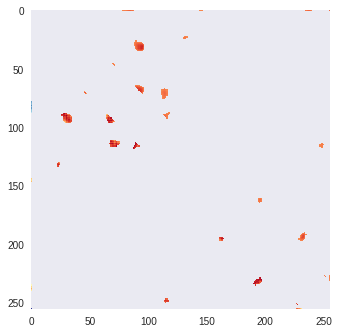

MAE for 1 - 16pkA0 = 7.16


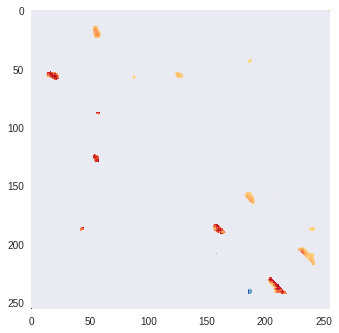

MAE for 2 - 16vpA0 = 6.56


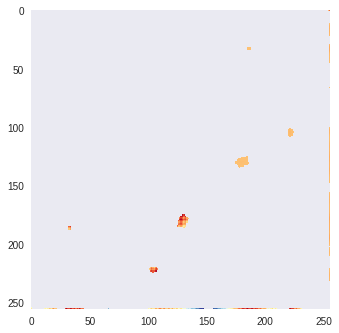

MAE for 3 - 1a0tP0 = 7.49


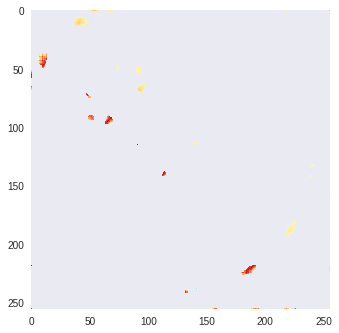

MAE for 4 - 1a2zA0 = 7.79
MAE for 5 - 1a8rA0 = 6.02
MAE for 6 - 1ahsA0 = 4.89
MAE for 7 - 1aihA0 = 5.04
Average MAE = 6.33

Evaluate on the test dataset..

MAE of top L long-range distance predictions on the test set..
MAE for 0 - 1a3aA = 2.58


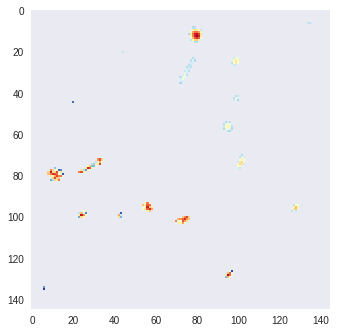

MAE for 1 - 1a6mA = 4.64


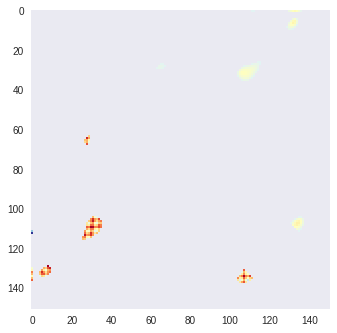

MAE for 2 - 1a70A = 2.85


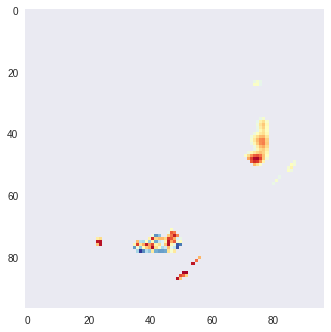

MAE for 3 - 1aapA = 2.32


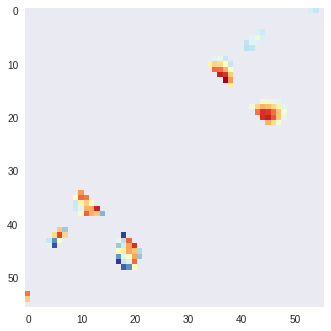

MAE for 4 - 1abaA = 2.59
MAE for 5 - 1ag6A = 3.84
MAE for 6 - 1aoeA = 3.54
MAE for 7 - 1atlA = 6.21
MAE for 8 - 1atzA = 2.82
MAE for 9 - 1avsA = 2.50
MAE for 10 - 1bdoA = 2.79
MAE for 11 - 1bebA = 6.93
MAE for 12 - 1behA = 6.47
MAE for 13 - 1bkrA = 3.56
MAE for 14 - 1brfA = 3.54
MAE for 15 - 1bsgA = 2.96
MAE for 16 - 1c44A = 6.33
MAE for 17 - 1c52A = 3.53
MAE for 18 - 1c9oA = 3.62
MAE for 19 - 1cc8A = 2.66
MAE for 20 - 1chdA = 2.22
MAE for 21 - 1cjwA = 5.21
MAE for 22 - 1ckeA = 2.92
MAE for 23 - 1ctfA = 3.52
MAE for 24 - 1cxyA = 2.13
MAE for 25 - 1cznA = 2.69
MAE for 26 - 1d0qA = 3.33
MAE for 27 - 1d1qA = 2.94
MAE for 28 - 1d4oA = 6.20
MAE for 29 - 1dbxA = 2.55
MAE for 30 - 1dixA = 7.17
MAE for 31 - 1dlwA = 2.75
MAE for 32 - 1dmgA = 3.77
MAE for 33 - 1dqgA = 4.27
MAE for 34 - 1dsxA = 2.65
MAE for 35 - 1eazA = 3.40
MAE for 36 - 1ej0A = 3.53
MAE for 37 - 1ej8A = 4.21
MAE for 38 - 1ek0A = 2.35
MAE for 39 - 1f6bA = 2.51
MAE for 40 - 1fcyA = 5.54
MAE for 41 - 1fk5A = 4.02
MAE for 42 - 1fl0A

In [3]:
# 4-6-2019
# Badri Adhikari
# https://badriadhikari.github.io/
################################################################################

import numpy as np
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.models import load_model
import datetime
import keras.backend as K
epsilon = K.epsilon()
from io import BytesIO, StringIO
from tensorflow.python.lib.io import file_io
import argparse

################################################################################
flag_show_plots = True # True for Notebooks, False otherwise
if flag_show_plots:
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure

################################################################################
dirlocal = './dataset/'
dirgcp = 'gs://protein-distance/'
dataset = 'sample' # 'sample' or 'full'
stamp = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S_%f')
modelfile = 'model-' + str(stamp) + '.h5'
max_epochs = 64
es_patience = 32
if dataset == 'sample':
    max_epochs = 8
    es_patience = 1

################################################################################
def determine_number_of_channels(input_features, pdb_list, length_dict):
    F = 0
    x = input_features[pdb_list[0]]
    l = length_dict[pdb_list[0]]
    for feature in x:
        if len(feature) == l:
            F += 2
        elif len(feature) == l * l:
            F += 1
        else:
            print('Expecting features to be either L or L*L !! Something went wrong!!', l, len(feature))
            sys.exit(1)
    return F

################################################################################
def print_max_avg_sum_of_each_channel(x):
    print(' Channel        Avg        Max        Sum')
    for i in range(len(x[0, 0, :])):
        (m, s, a) = (x[:, :, i].flatten().max(), x[:, :, i].flatten().sum(), x[:, :, i].flatten().mean())
        print(' %7s %10.4f %10.4f %10.1f' % (i, a, m, s))

################################################################################
# Roll out 1D features to two 2D features, all to 256 x 256 (because many are smaller)
def prepare_input_features_2D(pdbs, input_features, distance_maps_cb, length_dict, F):
    X = np.full((len(pdbs), 256, 256, F), 0.0)
    Y = np.full((len(pdbs), 256, 256, 1), 100.0)
    for i, pdb in enumerate(pdbs):
        x = input_features[pdb]
        y = distance_maps_cb[pdb]
        l = length_dict[pdb]
        newi = 0
        xmini = np.zeros((l, l, F))
        for feature in x:
            feature = np.array(feature)
            feature = feature.astype(np.float)
            if len(feature) == l:
                for k in range(0, l):
                    xmini[k, :, newi] = feature
                    xmini[:, k, newi + 1] = feature
                newi += 2
            elif len(feature) == l * l:
                xmini[:, :, newi] = feature.reshape(l, l)
                newi += 1
            else:
                print('Expecting features to be either L or L*L !! Something went wrong!!', l, len(feature))
                sys.exit(1)
        if l > 256:
            l = 256
        X[i, 0:l, 0:l, :] = xmini[:l, :l, :]
        Y[i, 0:l, 0:l, 0] = y[:l, :l]
    return X, Y

################################################################################
def plot_input_output_of_this_protein(X, Y):
    figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', frameon=True, edgecolor='k')
    for i in range(13):
        plt.subplot(7, 7, i + 1)
        plt.grid(None)
        plt.imshow(X[:, :, i], cmap='RdYlBu', interpolation='nearest')
    # Last plot is the true distance map
    plt.subplot(7, 7, 14)
    plt.grid(None)
    plt.imshow(Y[:, :], cmap='Spectral', interpolation='nearest')
    plt.show()

################################################################################
def calculate_mae(PRED, YTRUE, pdb_list, length_dict):
    plot_count = 0
    if flag_show_plots:
        plot_count = 4
    avg_mae = 0.0
    for i in range(0, len(PRED[:, 0, 0, 0])):
        L = length_dict[pdb_list[i]]
        P = np.zeros((L, L))
        # Average the predictions from both triangles (optional)
        # This can improve MAE by upto 6% reduction
        for j in range(0, L):
            for k in range(0, L):
                P[k, j] = (PRED[i, k, j, 0] + PRED[i, j, k, 0]) / 2.0
        Y = np.copy(YTRUE[i, 0:L, 0:L, 0])
        for j in range(0, L):
            for k in range(0, L):
                if k - j < 24:
                    P[j, k] = np.inf
                    Y[j, k] = np.inf
        p_dict = {}
        y_dict = {}
        for j in range(0, L):
            for k in range(0, L):
                p_dict[(j,k)] = P[j, k]
                y_dict[(j,k)] = Y[j, k]
        top_pairs = []
        x = L
        for pair in sorted(p_dict.items(), key=lambda x: x[1]):
            (k, v) = pair
            top_pairs.append(k)
            x -= 1
            if x == 0:
                break
        sum_mae = 0.0
        for pair in top_pairs:
            abs_dist = abs(y_dict[pair] - p_dict[pair])
            sum_mae += abs_dist
        sum_mae /= L
        avg_mae += sum_mae
        print('MAE for ' + str(i) + ' - ' + str(pdb_list[i]) + ' = %.2f' % sum_mae)
        if plot_count > 0:
            plot_count -= 1
            for j in range(0, L):
                for k in range(0, L):
                    if not (j, k) in top_pairs:
                        P[j, k] = np.inf
                        Y[j, k] = np.inf
            for j in range(0, L):
                for k in range(j, L):
                    P[k, j] = Y[j, k]
            plt.grid(None)
            plt.imshow(P, cmap='RdYlBu', interpolation='nearest')
            plt.show()
    print('Average MAE = %.2f' % (avg_mae / len(PRED[:, 0, 0, 0])))

################################################################################
def main(job_dir):
    print('job_dir = ', job_dir)
    ################################################################################
    print('')
    print('Load input features..')
    x = dirlocal + dataset + '-input-features.npy'
    if not os.path.isfile(x):
        x = BytesIO(file_io.read_file_to_string(dirgcp + dataset + '-input-features.npy', binary_mode=True))
    (pdb_list, length_dict, input_features) = np.load(x, encoding='latin1')

    ################################################################################
    print('')
    print('Load distance maps..')
    x = dirlocal + dataset + '-distance-maps-cb.npy'
    if not os.path.isfile(x):
        x = BytesIO(file_io.read_file_to_string(dirgcp + dataset + '-distance-maps-cb.npy', binary_mode=True))
    (pdb_list_y, distance_maps_cb) = np.load(x, encoding='latin1')

    ################################################################################
    print('')
    print ('Some cross checks on data loading..')
    for pdb in pdb_list:
        if not pdb in pdb_list_y:
            print ('I/O mismatch ', pdb)
            sys.exit(1)

    ################################################################################
    print('')
    print('Find the number of input channels..')
    F = determine_number_of_channels(input_features, pdb_list, length_dict)

    ################################################################################
    print('')
    print('Split into training and validation set (4%)..')
    split = int(0.04 * len(pdb_list))
    valid_pdbs = pdb_list[:split]
    train_pdbs = pdb_list[split:]

    print('Total validation proteins = ', len(valid_pdbs))
    print('Total training proteins = ', len(train_pdbs))

    ################################################################################
    print('')
    print ('Prepare the validation input and outputs..')
    XVALID, YVALID = prepare_input_features_2D(valid_pdbs, input_features, distance_maps_cb, length_dict, F)
    print(XVALID.shape)
    print(YVALID.shape)

    print('')
    print ('Prepare the training input and outputs..')
    XTRAIN, YTRAIN = prepare_input_features_2D(train_pdbs, input_features, distance_maps_cb, length_dict, F)
    print(XTRAIN.shape)
    print(YTRAIN.shape)

    ################################################################################
    print('')
    print('Sanity check input features values..')
    print(' First validation protein:')
    print_max_avg_sum_of_each_channel(XVALID[0, :, :, :])
    print(' First traininig protein:')
    print_max_avg_sum_of_each_channel(XTRAIN[0, :, :, :])

    ################################################################################
    if flag_show_plots:
        import matplotlib.pyplot as plt
        from matplotlib.pyplot import figure
        for i in range(4):
            print('')
            L = length_dict[valid_pdbs[i]]
            plot_input_output_of_this_protein(XVALID[i, 0:L, 0:L, :], YVALID[i, 0:L, 0:L, 0])

    ################################################################################
    print('')
    print('Build a model..')
    input = Input(shape = (256, 256, F))
    tower = BatchNormalization()(input)
    tower = Activation('relu')(tower)
    tower = Convolution2D(64, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(64, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(64, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(64, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(64, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(64, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(64, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(1, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    model = Model(input, tower)

    ################################################################################
    model.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mae'])
    print (model.summary())

    ################################################################################
    # a simple early stopping
    mc = ModelCheckpoint(modelfile, monitor = 'val_mean_absolute_error', mode = 'min', verbose = 1, save_best_only = True)
    es = EarlyStopping(monitor = 'val_mean_absolute_error', mode = 'min', verbose = 1, patience = es_patience)
    print('')
    print('Train the model..')
    global max_epochs
    history = model.fit(XTRAIN, YTRAIN, verbose = 2, batch_size = 2, epochs = max_epochs, validation_data=(XVALID, YVALID), callbacks=[es, mc])

    if job_dir.startswith('gs'):
        print ('')
        print ('Save model weights on to google storage..')
        with file_io.FileIO(modelfile, mode='r') as input_f:
            with file_io.FileIO(job_dir + modelfile, mode = 'w+') as output_f:
                output_f.write(input_f.read())
        print('Saved best weights to ' + job_dir + modelfile)

    ################################################################################
    print('')
    print('Cuves..')
    if flag_show_plots:
        import matplotlib.pyplot as plt
        from matplotlib.pyplot import figure
        print(history.params)
        plt.clf()
        plt.plot(history.history['mean_absolute_error'], 'g', label='Training MAE')
        plt.plot(history.history['val_mean_absolute_error'], 'b', label='Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

    ################################################################################
    print('')
    print('Load the best weights..')
    model = load_model(modelfile, compile = False)

    ################################################################################
    print('')
    print('Make predictions..')
    P = model.predict(XVALID)
    print('')
    print('Compare the predictions with the truths (for some proteins) ..')
    if flag_show_plots:
        import matplotlib.pyplot as plt
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', frameon=True, edgecolor='k')
        I = 1
        for k in range(4):
            L = length_dict[pdb_list[k]]
            plt.subplot(4, 4, I)
            I += 1
            plt.grid(None)
            plt.imshow(P[k, 0:L, 0:L, 0], cmap='RdYlBu', interpolation='nearest')
        for k in range(4):
            L = length_dict[pdb_list[k]]
            plt.subplot(4, 4, I)
            I += 1
            plt.grid(None)
            plt.imshow(YVALID[k, 0:L, 0:L, 0], cmap='Spectral', interpolation='nearest')
        plt.show()

    ################################################################################
    print('')
    print('MAE of top L long-range distance predictions on the validation set..')
    calculate_mae(P, YVALID, valid_pdbs, length_dict)

    ################################################################################
    print('')
    print('Evaluate on the test dataset..')
    model = load_model(modelfile, compile = False)
    x = dirlocal + 'testset-input-features.npy'
    if not os.path.isfile(x):
        x = BytesIO(file_io.read_file_to_string(dirgcp + 'testset-input-features.npy', binary_mode=True))
    (pdb_list, length_dict, sequence_dict, input_features)  = np.load(x)
    x = dirlocal + 'testset-distance-maps-cb.npy'
    if not os.path.isfile(x):
        x = BytesIO(file_io.read_file_to_string(dirgcp + 'testset-distance-maps-cb.npy', binary_mode=True))
    (pdb_list_y, distance_maps_cb) = np.load(x)
    F = determine_number_of_channels(input_features, pdb_list, length_dict)
    XTEST, YTEST = prepare_input_features_2D(pdb_list, input_features, distance_maps_cb, length_dict, F)
    P = model.predict(XTEST)
    for pdb in length_dict:
        if length_dict[pdb] > 256:
            length_dict[pdb] = 256
    print('')
    print('MAE of top L long-range distance predictions on the test set..')
    calculate_mae(P, YTEST, pdb_list, length_dict)

################################################################################
main('./')